In [1]:
import pandas as pd
import numpy as np

import time

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
import pyspark.sql.functions as sf
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, FMClassifier
from pyspark.ml import Pipeline
from pyspark.sql import types as st

from replay.models import RandomRec

from sim4rec.utils import pandas_to_spark, VectorElementExtractor
from sim4rec.modules import RealDataGenerator
from sim4rec.modules import Simulator
from sim4rec.response import ParametricResponseFunction, BernoulliResponse, NoiseResponse

from replay.models import ThompsonSampling

%matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore")

spark = SparkSession.builder\
    .appName('simulator_movielens')\
    .master('local[*]')\
    .config('spark.sql.shuffle.partitions', '192')\
    .config('spark.default.parallelism', '192')\
    .config('spark.driver.memory', '256g')\
    .config('spark.driver.maxResultSize', '256g')\
    .getOrCreate()

24/04/24 15:03:36 WARN Utils: Your hostname, ecs-syudosaev-big resolves to a loopback address: 127.0.1.1; using 10.11.12.124 instead (on interface eth0)
24/04/24 15:03:36 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/04/24 15:03:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
USER_PREFIX = 'user_'
ITEM_PREFIX = 'item_'

USER_SCHEMA = st.StructType(
    [st.StructField('user_idx', st.IntegerType())] +\
    [st.StructField(f'genre{i}', st.DoubleType()) for i in range(19)] +\
    [st.StructField('rating_avg', st.DoubleType())] +\
    [st.StructField(f'w2v_{i}', st.DoubleType()) for i in range(300)]
)
ITEM_SCHEMA = st.StructType(
    [st.StructField('item_idx', st.IntegerType())] +\
    [st.StructField('year', st.IntegerType())] +\
    [st.StructField('rating_avg', st.DoubleType())] +\
    [st.StructField(f'genre{i}', st.DoubleType()) for i in range(19)] +\
    [st.StructField(f'w2v_{i}', st.DoubleType()) for i in range(300)]
)
LOG_SCHEMA = st.StructType([
    st.StructField('user_idx', st.IntegerType()),
    st.StructField('item_idx', st.IntegerType()),
    st.StructField('relevance', st.DoubleType()),
    st.StructField('timestamp', st.IntegerType())
])

users_df_train = spark.read.csv('train/users.csv', header=True, schema=USER_SCHEMA)
items_df_train = spark.read.csv('train/items.csv', header=True, schema=ITEM_SCHEMA)
log_df_train   = spark.read.csv('train/rating.csv', header=True, schema=LOG_SCHEMA)

log_df_train = log_df_train.join(users_df_train, log_df_train['user_idx'] == users_df_train['user_idx'], 'leftsemi')
log_df_train = log_df_train.join(items_df_train, log_df_train['item_idx'] == items_df_train['item_idx'], 'leftsemi')

for c in users_df_train.columns[1:]:
    users_df_train = users_df_train.withColumnRenamed(c, 'user_' + c)
    
for c in items_df_train.columns[1:]:
    items_df_train = items_df_train.withColumnRenamed(c, 'item_' + c)

log_df_train = log_df_train.withColumn(
    'relevance', sf.when(sf.col('relevance') >= 3, 1).otherwise(0))

users_df_train = users_df_train.cache()
items_df_train = items_df_train.cache()
log_df_train = log_df_train.cache()

print(users_df_train.count())
print(items_df_train.count())
print(log_df_train.count())

24/04/24 15:04:16 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


80650


27278


10000132


In [3]:
users_df_val = spark.read.csv('val/users.csv', header=True, schema=USER_SCHEMA)
items_df_val = spark.read.csv('val/items.csv', header=True, schema=ITEM_SCHEMA)
log_df_val   = spark.read.csv('val/rating.csv', header=True, schema=LOG_SCHEMA)

log_df_val = log_df_val.join(users_df_val, log_df_val['user_idx'] == users_df_val['user_idx'], 'leftsemi')
log_df_val = log_df_val.join(items_df_val, log_df_val['item_idx'] == items_df_val['item_idx'], 'leftsemi')

for c in users_df_val.columns[1:]:
    users_df_val = users_df_val.withColumnRenamed(c, 'user_' + c)

for c in items_df_val.columns[1:]:
    items_df_val = items_df_val.withColumnRenamed(c, 'item_' + c)

log_df_val = log_df_val.withColumn(
    'relevance', sf.when(sf.col('relevance') >= 3, 1).otherwise(0))

users_df_val = users_df_val.cache()
items_df_val = items_df_val.cache()
log_df_val = log_df_val.cache()

print(users_df_val.count())
print(items_df_val.count())
print(log_df_val.count())

106573
27278
5000065


In [4]:
users_df_test = spark.read.csv('test/users.csv', header=True, schema=USER_SCHEMA)
items_df_test = spark.read.csv('test/items.csv', header=True, schema=ITEM_SCHEMA)
log_df_test   = spark.read.csv('test/rating.csv', header=True, schema=LOG_SCHEMA)

log_df_test = log_df_test.join(users_df_test, log_df_test['user_idx'] == users_df_test['user_idx'], 'leftsemi')
log_df_test = log_df_test.join(items_df_test, log_df_test['item_idx'] == items_df_test['item_idx'], 'leftsemi')

for c in items_df_test.columns[1:]:
    items_df_test = items_df_test.withColumnRenamed(c, 'item_' + c)

log_df_test = log_df_test.withColumn(
    'relevance', sf.when(sf.col('relevance') >= 3, 1).otherwise(0))

items_df_test = items_df_test.na.drop()

items_df_test = items_df_test.cache()
log_df_test = log_df_test.cache()

print(log_df_test.count())

5000066


In [5]:
train_df = log_df_val.join(items_df_train, 'item_idx', 'left')\
                     .join(users_df_train, 'user_idx', 'left')\
                     .drop('timestamp')

test_df = log_df_test.join(items_df_val, 'item_idx', 'left')\
                     .join(users_df_val, 'user_idx', 'left')\
                     .drop('timestamp')

item_svd = spark.read.csv('item_svd.csv', header=True, inferSchema=True).withColumnRenamed('item_id', 'item_idx')
user_svd = spark.read.csv('user_svd.csv', header=True, inferSchema=True).withColumnRenamed('user_id', 'user_idx')

train_df = train_df.join(item_svd, on='item_idx', how='left')
train_df = train_df.join(user_svd, on='user_idx', how='left')

test_df = test_df.join(item_svd, on='item_idx', how='left')
test_df = test_df.join(user_svd, on='user_idx', how='left')

train_df = train_df.na.drop()
test_df = test_df.na.drop()

train_df.write.parquet('final_train.parquet', mode='overwrite')
test_df.write.parquet('final_test.parquet', mode='overwrite')

In [7]:
print('train statistics')
print(train_df.count())
print(train_df.select('user_idx').distinct().count())
print(train_df.select('item_idx').distinct().count())
print(train_df.count() / (train_df.select('user_idx').distinct().count() * train_df.select('item_idx').distinct().count()))
print()

print('test statistics')
print(test_df.count())
print(test_df.select('user_idx').distinct().count())
print(test_df.select('item_idx').distinct().count())
print(test_df.count() / (test_df.select('user_idx').distinct().count() * test_df.select('item_idx').distinct().count()))

train statistics


402391


4207


7816


0.012237457481182967

test statistics


89829


1709


6748


0.007789317893380107


In [ ]:
train_df = spark.read.parquet('final_train.parquet')
test_df = spark.read.parquet('final_test.parquet')

va = VectorAssembler(
    inputCols=items_df_train.columns[2:] + users_df_train.columns[1:],
    outputCol='features'
)

fm = FMClassifier(
    featuresCol='features',
    labelCol='relevance',
    probabilityCol='proba'
)

rf = RandomForestClassifier(
    featuresCol='features',
    labelCol='relevance',
    probabilityCol='proba'
)

lr = LogisticRegression(
    featuresCol='features',
    labelCol='relevance',
    probabilityCol='proba'
)

vee = VectorElementExtractor(inputCol='proba', outputCol='scores', index=1)
mc = ParametricResponseFunction(inputCols=['scores'], outputCol='__pr', weights=[0.25])
br = BernoulliResponse(inputCol='__pr', outputCol='response', seed=1234)
pipeline_lr = Pipeline(stages=[va, lr, vee, mc, br])
pipeline_rf = Pipeline(stages=[va, rf, vee, mc, br])
pipeline_fm = Pipeline(stages=[va, fm, vee, mc, br])

noise_resp = NoiseResponse(mu=0.5, sigma=0.2, outputCol='scores')
br = BernoulliResponse(inputCol='scores', outputCol='response')
pipeline_rand = Pipeline(stages=[noise_resp, br])

lr_model = pipeline_lr.fit(train_df)
# rf_model = pipeline_rf.fit(train_df)
# fm_model = pipeline_fm.fit(train_df)
# rand_model = pipeline_rand.fit(train_df)

24/04/24 14:30:10 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/04/24 14:30:10 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


24/04/24 14:30:14 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
24/04/24 14:30:14 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [ ]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score

def get_baseline(test_df):
    test_df = test_df.select('item_rating_avg', 'relevance').toPandas()
    test_df['baseline'] = (test_df['item_rating_avg']-test_df['item_rating_avg'].min())/(test_df['item_rating_avg'].max()-test_df['item_rating_avg'].min())
    test_df['baseline_bin'] = np.where(test_df['baseline'] > 0.5, 1, 0) 
    print(f"ROC AUC (baseline): {roc_auc_score(test_df.relevance, test_df.baseline)}")
    print(f"Precision (baseline): {precision_score(test_df.relevance, test_df.baseline_bin)}")
    print(f"Recall (baseline): {recall_score(test_df.relevance, test_df.baseline_bin)}")
    print(f"Accuracy (baseline): {accuracy_score(test_df.relevance, test_df.baseline_bin)}")
    print(f"F1 (baseline): {f1_score(test_df.relevance, test_df.baseline_bin)}")
    print()

def assess_models(model, test_df):
    pred_df = model.transform(test_df).select("relevance", "scores").toPandas()
    pred_df['response_bin'] = np.where(pred_df['scores'] > 0.5, 1, 0)
    print(f"ROC AUC (classificator): {roc_auc_score(pred_df.relevance, pred_df.scores)}")
    print(f"Precision (classificator): {precision_score(pred_df.relevance, pred_df.response_bin)}")
    print(f"Recall (classificator): {recall_score(pred_df.relevance, pred_df.response_bin)}")
    print(f"Accuracy (classificator): {accuracy_score(pred_df.relevance, pred_df.response_bin)}")
    print(f"F1 (classificator): {f1_score(pred_df.relevance, pred_df.response_bin)}")
    print()

# get_baseline(test_df)
assess_models(lr_model, test_df)
# assess_models(rf_model, test_df)
# assess_models(fm_model, test_df)
# assess_models(rand_model, test_df)

In [ ]:
# BASELINE

# ROC AUC (baseline): 0.582591123278372
# Precision (baseline): 0.8167168049900662
# Recall (baseline): 0.6070843580362276
# Accuracy (baseline): 0.5741678347491657
# F1 (baseline): 0.6964680323774068

# RANDOM

# ROC AUC (classificator): 0.4978546228997185
# Precision (classificator): 0.8037183230642253
# Recall (classificator): 0.4994878422585149
# Accuracy (classificator): 0.49905223199365495
# F1 (classificator): 0.6160921297844889


# ONLY SVD
# LR
# ROC AUC (classificator): 0.5401508841365394
# Precision (classificator): 0.8047410847454245
# Recall (classificator): 1.0
# Accuracy (classificator): 0.8047410847454245
# F1 (classificator): 0.8918077961958081

# RF
# ROC AUC (classificator): 0.53787730764202
# Precision (classificator): 0.8047410847454245
# Recall (classificator): 1.0
# Accuracy (classificator): 0.8047410847454245
# F1 (classificator): 0.8918077961958081

# FM
# ROC AUC (classificator): 0.5741205172469663
# Precision (classificator): 0.8049914790284219
# Recall (classificator): 0.9991647412324948
# Accuracy (classificator): 0.8045428017019918
# F1 (classificator): 0.8916291103898707


# ONLY BASE FEATURES

# LR
# ROC AUC (classificator): 0.7180440343733357
# Precision (classificator): 0.8347450148784075
# Recall (classificator): 0.9454943290733586
# Accuracy (classificator): 0.8055055344663318
# F1 (classificator): 0.8866747951293167

# RF
# ROC AUC (classificator): 0.6642930786535302
# Precision (classificator): 0.8047410847454245
# Recall (classificator): 1.0
# Accuracy (classificator): 0.8047410847454245
# F1 (classificator): 0.8918077961958081

# FM
# ROC AUC (classificator): 0.6755055487545727
# Precision (classificator): 0.8138726679301715
# Recall (classificator): 0.9842122146134642
# Accuracy (classificator): 0.8061614896917759
# F1 (classificator): 0.8909739786964518


# All Features

# LR
# ROC AUC (classificator): 0.7198633684425806
# Precision (classificator): 0.8350650025858742
# Recall (classificator): 0.9458166552767744
# Accuracy (classificator): 0.8060629717016426
# F1 (classificator): 0.8869970491271999

# RF
# ROC AUC (classificator): 0.6829319011020921
# Precision (classificator): 0.8047410847454245
# Recall (classificator): 1.0
# Accuracy (classificator): 0.8047410847454245
# F1 (classificator): 0.8918077961958081

# FM
# ROC AUC (classificator): 0.6753245513076216
# Precision (classificator): 0.8610686655103108
# Recall (classificator): 0.775439363157805
# Accuracy (classificator): 0.7186014436003212
# F1 (classificator): 0.8160137633566935

In [ ]:
# DROP no embeds

# Baseline 

# ROC AUC (baseline): 0.7372742266277569
# Precision (baseline): 0.8376844361229849
# Recall (baseline): 0.9745328511151296
# Accuracy (baseline): 0.8258580191252268
# F1 (baseline): 0.9009416338962872

# RANDOM

# ROC AUC (classificator): 0.4968626700791594
# Precision (classificator): 0.8118302328171995
# Recall (classificator): 0.4991917365335087
# Accuracy (classificator): 0.4990147947767425
# F1 (classificator): 0.6182336424020834


# Only SVD

# LR
# ROC AUC (classificator): 0.5464820885361235
# Precision (classificator): 0.8126106268576962
# Recall (classificator): 1.0
# Accuracy (classificator): 0.8126106268576962
# F1 (classificator): 0.8966190695532013

# RF
# ROC AUC (classificator): 0.577793365350413
# Precision (classificator): 0.8126106268576962
# Recall (classificator): 1.0
# Accuracy (classificator): 0.8126106268576962
# F1 (classificator): 0.8966190695532013

# FM
# ROC AUC (classificator): 0.6091758621796814
# Precision (classificator): 0.8141132692975869
# Recall (classificator): 0.9950682229163241
# Accuracy (classificator): 0.8113638134678111
# F1 (classificator): 0.8955411578317931


# All features

# LR
# ROC AUC (classificator): 0.7625562576754742
# Precision (classificator): 0.8582738221794214
# Recall (classificator): 0.9401200065757028
# Accuracy (classificator): 0.8251900833806455
# F1 (classificator): 0.8973344752963329

# RF
# ROC AUC (classificator): 0.7087306251422736
# Precision (classificator): 0.8126106268576962
# Recall (classificator): 1.0
# Accuracy (classificator): 0.8126106268576962
# F1 (classificator): 0.8966190695532013

# FM
# ROC AUC (classificator): 0.7013788751892476
# Precision (classificator): 0.8707407735197805
# Recall (classificator): 0.8086881472957422
# Accuracy (classificator): 0.7469859399525766
# F1 (classificator): 0.8385680801193267


# Only base features

# LR
# ROC AUC (classificator): 0.7609366161740678
# Precision (classificator): 0.8574875904925043
# Recall (classificator): 0.9395172338210313
# Accuracy (classificator): 0.8239655345155796
# F1 (classificator): 0.8966301683281583

# RF
# ROC AUC (classificator): 0.7118090411336161
# Precision (classificator): 0.8126106268576962
# Recall (classificator): 1.0
# Accuracy (classificator): 0.8126106268576962
# F1 (classificator): 0.8966190695532013

# FM
# ROC AUC (classificator): 0.716919842422077
# Precision (classificator): 0.8468572410491819
# Recall (classificator): 0.9452024768480465
# Accuracy (classificator): 0.8165737122755458
# F1 (classificator): 0.8933313480374703

In [8]:
train_users_counts = test_df.groupBy("item_idx").agg(sf.count('user_idx').alias('counts'))
train_users_counts = train_users_counts.sort('counts', ascending=False).limit(100).select('item_idx')
test_df = test_df.join(train_users_counts, on='item_idx', how='inner')       

print('test statistics')
print(test_df.count())
print(test_df.select('user_idx').distinct().count())
print(test_df.select('item_idx').distinct().count())
print(test_df.count() / (test_df.select('user_idx').distinct().count() * test_df.select('item_idx').distinct().count()))

test statistics


10196


1348


100


0.0756379821958457


In [9]:
item_generator = RealDataGenerator(label='items_real', seed=42)
user_generator = RealDataGenerator(label='users_real', seed=42)

users_df = test_df.select(*users_df_train.columns).distinct().cache()
items_df = test_df.select(*items_df_train.columns).drop('item_year').distinct().cache()

# передадим популяции пользователей и айтемов
item_generator.fit(items_df)
user_generator.fit(users_df)

# будем использовать всех пользователей и айтемы из популяции
item_generator.generate(items_df.count())
user_generator.generate(users_df.count())

24/04/24 15:17:28 WARN CacheManager: Asked to cache already cached data.
24/04/24 15:17:28 WARN CacheManager: Asked to cache already cached data.


In [10]:
dummy_log = interactions=pandas_to_spark(pd.DataFrame({'user_idx' : [1], 'item_idx' : [1], 'relevance' : [0.0]}))

ts_lr = ThompsonSampling(sample=True)
ts_lr.fit(dummy_log)

ts_rf = ThompsonSampling(sample=True)
ts_rf.fit(dummy_log)

ts_fm = ThompsonSampling(sample=True)
ts_fm.fit(dummy_log)

ts_rand = ThompsonSampling(sample=True)
ts_rand.fit(dummy_log)

24/04/24 14:33:38 WARN HintErrorLogger: A join hint (strategy=broadcast) is specified but it is not part of a join relation.
24/04/24 14:33:38 WARN HintErrorLogger: A join hint (strategy=broadcast) is specified but it is not part of a join relation.
24/04/24 14:33:39 WARN HintErrorLogger: A join hint (strategy=broadcast) is specified but it is not part of a join relation.
24/04/24 14:33:39 WARN HintErrorLogger: A join hint (strategy=broadcast) is specified but it is not part of a join relation.
24/04/24 14:33:40 WARN HintErrorLogger: A join hint (strategy=broadcast) is specified but it is not part of a join relation.
24/04/24 14:33:40 WARN HintErrorLogger: A join hint (strategy=broadcast) is specified but it is not part of a join relation.
24/04/24 14:33:41 WARN HintErrorLogger: A join hint (strategy=broadcast) is specified but it is not part of a join relation.
24/04/24 14:33:41 WARN HintErrorLogger: A join hint (strategy=broadcast) is specified but it is not part of a join relation.


In [7]:
def calc_metric(response_df):
    return (response_df
            .groupBy("user_idx").agg(sf.sum("response").alias("num_positive"))
            .select(sf.mean("num_positive")).collect()[0][0]
           )

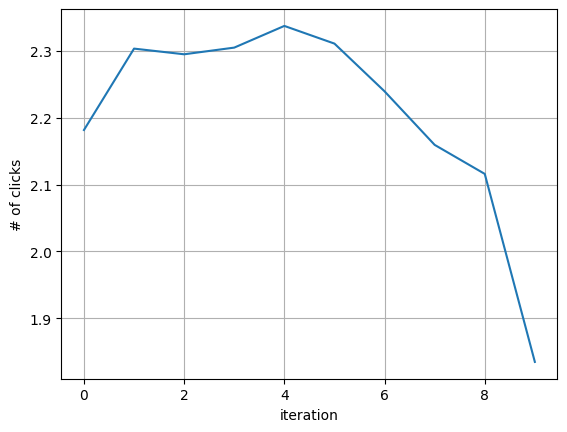

Time of 50 iteration: 
25.26887583732605


In [11]:
def plot_metric(metrics):
    clear_output(wait=True)
    plt.plot(metrics)
    plt.grid()
    plt.xlabel('iteration')
    plt.ylabel('# of clicks')
    plt.show()

def do_a_cycle(simul, model, pipeline, iteration, metrics):
    users = simul.sample_users(1.0).dropna().cache()
    log = simul.get_log(user_df=users)
    log = dummy_log if log is None else log

    recs = model.predict(
        log,
        k=10,
        users=users,
        items=items_df,
    )
    resp = simul.sample_responses(
        recs_df=recs, 
        user_features=users,
        item_features=items_df,
        action_models=pipeline
    ).select('user_idx', 'item_idx', 'relevance', 'response').cache()
    simul.update_log(resp, iteration=iteration)
    met = calc_metric(resp)
    metrics.append(met)

    model._clear_cache()
    train_log = simul.log.cache()
    model.fit(train_log.select('user_idx', 'item_idx', 'response').withColumnRenamed('response', 'relevance'))

    log.unpersist()
    users.unpersist()
    recs.unpersist()
    resp.unpersist()
    train_log.unpersist()

sim_lr = Simulator(user_generator, item_generator, f'checkpoints/lr', None, 'user_idx', 'item_idx', spark)
sim_rf = Simulator(user_generator, item_generator, f'checkpoints/rf', None, 'user_idx', 'item_idx', spark)
sim_fm = Simulator(user_generator, item_generator, f'checkpoints/fm', None, 'user_idx', 'item_idx', spark)
sim_rand = Simulator(user_generator, item_generator, f'checkpoints/rand', None, 'user_idx', 'item_idx', spark)

lr_metrics = []
rf_metrics = []
fm_metrics = []
rnd_metrics = []

for i in range(50):
    print(f'------------------------Stage {i}------------------------')
    start_iter = time.time()

    do_a_cycle(sim_lr, ts_lr, lr_model, i, lr_metrics)
    # do_a_cycle(sim_rf, ts_rf, rf_model, i, rf_metrics)
    # do_a_cycle(sim_fm, ts_fm, fm_model, i, fm_metrics)
    # do_a_cycle(sim_rand, ts_rand, rand_model, i, rnd_metrics)
    plot_metric(lr_metrics)
    end_iter = time.time()
    print(f"Time of {i+1} iteration: ")
    print(end_iter - start_iter)